In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, make_scorer

from sklearn.metrics import matthews_corrcoef
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler



import matplotlib.pyplot as plt
%matplotlib inline

    0. clf -> essembler: xgboost, random forest, rgb, nn, svm
    1. downsampling / normalization for GD
        extract same number of 0 and 1 
    2. cross_validation for model selection
        fine-tune hyper parameter
        set of features
3. feature ranking
    rfe


# feature rank for raw numeric data

In [2]:
chunk_size = 100000

train_raw_numeric_dir = './Raw/train_numeric.csv'
train_count_dup_dir = './Numeric/train_dup_int.csv'
train_datetime_dir = './Datetime/datetime_train.csv'
train_faron_dir = './faron_data/faron_feat_train.csv'


y = pd.read_csv(train_raw_numeric_dir, usecols=[0, 969], dtype=np.float32)
#.loc[X.index].values.ravel()
tr_x, te_x, tr_y, te_y = train_test_split(y['Id'], y['Response'].values, test_size=0.05, random_state=42)

print(sorted(Counter(tr_y).items()))
print(sorted(Counter(te_y).items()))

sample_index = te_x.values.ravel()
chunk1 = pd.read_csv(train_raw_numeric_dir, chunksize=chunk_size, dtype=np.float32,
                     usecols=list(range(969)))

    
%time X = pd.concat([chunk.loc[chunk['Id'].isin(sample_index)] for chunk in chunk1])
X = X.set_index('Id')


[(0.0, 1118039), (1.0, 6520)]
[(0.0, 58829), (1.0, 359)]
CPU times: user 1min 47s, sys: 2.6 s, total: 1min 50s
Wall time: 1min 50s


In [3]:
X = X.fillna(X.mean())
X = X.values

rf_clf = RandomForestClassifier(n_estimators=325, min_samples_split=150, 
                                n_jobs=-1, oob_score=True, random_state=42)
rf_clf.fit(X, te_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=150,
            min_weight_fraction_leaf=0.0, n_estimators=325, n_jobs=-1,
            oob_score=True, random_state=42, verbose=0, warm_start=False)

(array([597., 141.,  53.,  10.,  13.,   5.,   3.,   2.,   1.,   2.]),
 array([2.96087526e-09, 1.50541166e-03, 3.01082036e-03, 4.51622906e-03,
        6.02163776e-03, 7.52704646e-03, 9.03245516e-03, 1.05378639e-02,
        1.20432726e-02, 1.35486813e-02, 1.50540900e-02]),
 <a list of 10 Patch objects>)

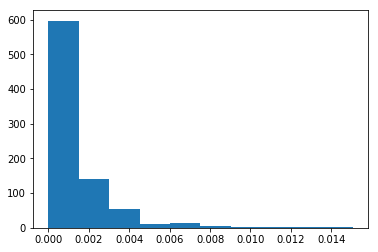

In [4]:
plt.hist(rf_clf.feature_importances_[rf_clf.feature_importances_>0])

In [5]:
print(X.shape, te_y.shape)


(59188, 968) (59188,)


In [6]:
impt_idx = np.where(rf_clf.feature_importances_>0.003)[0]
print(impt_idx.shape)

(89,)


# Read numeric dataset based one rank

In [8]:
X = pd.concat([
    pd.read_csv(train_datetime_dir, index_col=0, dtype=np.float32),
    pd.read_csv(train_count_dup_dir, index_col=0, dtype=np.float32),
    #pd.read_csv(train_faron_dir, index_col=0, dtype=np.float32, usecols=[1,4,5,6,7]),
    pd.read_csv(train_raw_numeric_dir, index_col=0, dtype=np.float32,
               usecols=np.concatenate([[0], impt_idx+1]))
], axis=1)


y = pd.read_csv(train_raw_numeric_dir, index_col=0, dtype=np.float32, usecols=[0,969]).values.ravel()

print(X.shape, y.shape)

X = X.fillna(X.mean())
X = X.values

#%time print(sorted(Counter(y).items()))
print(sorted(Counter(y).items()))

/home/wangxt/miniconda3/envs/tf14c36/lib/python3.6/site-packages/numpy/lib/arraysetops.py:466: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


(1183747, 206) (1183747,)
[(0.0, 1176868), (1.0, 6879)]


In [10]:
cc = RandomUnderSampler(random_state=42) 
X_resampled, y_resampled = cc.fit_sample(X, y)
param_grid = {
    'n_estimators': [300, 325, 350],
    'min_samples_split': [100, 150, 200],
}
scoring = {'mcc': make_scorer(matthews_corrcoef)}

rfc = RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=42)
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, scoring=scoring, cv=2, verbose=3, n_jobs=-1, refit='mcc')
CV_rfc.fit(X_resampled, y_resampled)

print(CV_rfc.best_params_)

Fitting 2 folds for each of 9 candidates, totalling 18 fits
[CV] min_samples_split=100, n_estimators=325 .........................
[CV] min_samples_split=100, n_estimators=350 .........................
[CV] min_samples_split=100, n_estimators=300 .........................
[CV] min_samples_split=100, n_estimators=325 .........................
[CV] min_samples_split=100, n_estimators=300 .........................
[CV] min_samples_split=100, n_estimators=350 .........................
[CV] min_samples_split=150, n_estimators=300 .........................
[CV] min_samples_split=150, n_estimators=300 .........................
[CV]  min_samples_split=150, n_estimators=300, mcc=0.36055604892518933, total=  19.9s
[CV] min_samples_split=150, n_estimators=325 .........................
[CV]  min_samples_split=100, n_estimators=300, mcc=0.3645841723780613, total=  20.0s
[CV] min_samples_split=150, n_estimators=325 .........................
[CV]  min_samples_split=100, n_estimators=300, mcc=0.330834

[Parallel(n_jobs=-1)]: Done  10 out of  18 | elapsed:   42.6s remaining:   34.1s


[CV]  min_samples_split=150, n_estimators=325, mcc=0.3287973041410779, total=  18.8s
[CV]  min_samples_split=150, n_estimators=325, mcc=0.35782279037973747, total=  20.1s
[CV]  min_samples_split=150, n_estimators=350, mcc=0.35983572098761796, total=  20.0s
[CV]  min_samples_split=150, n_estimators=350, mcc=0.3273332362458413, total=  20.3s
[CV]  min_samples_split=200, n_estimators=325, mcc=0.32182681596981744, total=  19.4s
[CV]  min_samples_split=200, n_estimators=350, mcc=0.3570812964952302, total=   6.9s
[CV]  min_samples_split=200, n_estimators=350, mcc=0.3210017258072155, total=   6.7s


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   49.7s finished


{'min_samples_split': 100, 'n_estimators': 325}


# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

cc = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = cc.fit_sample(X_train, y_train)

rfc = RandomForestClassifier(n_estimators=200, min_samples_split=50,
                             n_jobs=-1, random_state=42)
preds = np.ones(y_test.shape[0])
preds = rfc.fit(X_resampled, y_resampled).predict_proba(X_test)[:,1]
print(roc_auc_score(y_test, preds))

thresholds = np.linspace(0.01, 0.99, 50)
mcc = np.array([matthews_corrcoef(y_test, preds>thr) for thr in thresholds])
plt.plot(thresholds, mcc)
best_threshold = thresholds[mcc.argmax()]
print('mcc: ', mcc.max())


#print(sorted(Counter(y_train).items()))
#print(sorted(Counter(y_test).items()))
cc = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = cc.fit_sample(X, y)

print(sorted(Counter(y_resampled).items()))

[(0.0, 784578), (1.0, 4586)]
[(0.0, 784578), (1.0, 4586)]
start cv fold  0
fold 0, ROC AUC: 0.760
[(0.0, 784579), (1.0, 4586)]
[(0.0, 784579), (1.0, 4586)]
start cv fold  1
fold 1, ROC AUC: 0.746
[(0.0, 784579), (1.0, 4586)]
[(0.0, 784579), (1.0, 4586)]
start cv fold  2
fold 2, ROC AUC: 0.745
0.7499584252083781


/home/wangxt/miniconda3/envs/tf14c36/lib/python3.6/site-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


mcc:  0.152170890856433


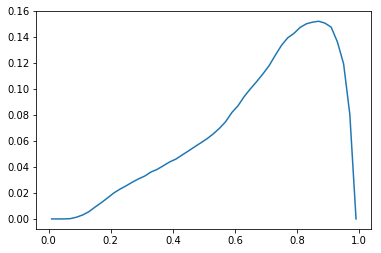

In [11]:
# cv downsampling

skf = StratifiedKFold(n_splits=3)
preds = np.ones(y.shape[0])
rfc = RandomForestClassifier(n_estimators=325, min_samples_split=100,
                             n_jobs=-1, oob_score=True, random_state=42)


cnt = 0
for train, test in skf.split(X, y):
    print(sorted(Counter(y[train]).items()))
    X_resampled, y_resampled = cc.fit_sample(X[train], y[train])
    print(sorted(Counter(y[train]).items()))
    print('start cv fold ', cnt)
    preds[test] = rfc.fit(X_resampled, y_resampled).predict_proba(X[test])[:,1]
    print("fold {}, ROC AUC: {:.3f}".format(cnt, roc_auc_score(y[test], preds[test])))
    cnt+=1
    
print(roc_auc_score(y, preds))
thresholds = np.linspace(0.01, 0.99, 50)
mcc = np.array([matthews_corrcoef(y, preds>thr) for thr in thresholds])
plt.plot(thresholds, mcc)
best_threshold = thresholds[mcc.argmax()]
print('mcc: ', mcc.max())

[(0.0, 784578), (1.0, 4586)]
[(0.0, 784578), (1.0, 4586)]
start cv fold  0
fold 0, ROC AUC: 0.766
[(0.0, 784579), (1.0, 4586)]
[(0.0, 784579), (1.0, 4586)]
start cv fold  1
fold 1, ROC AUC: 0.751
[(0.0, 784579), (1.0, 4586)]
[(0.0, 784579), (1.0, 4586)]
start cv fold  2
fold 2, ROC AUC: 0.745
0.7539316932325084


/home/wangxt/miniconda3/envs/tf14c36/lib/python3.6/site-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


mcc:  0.16982592860961662


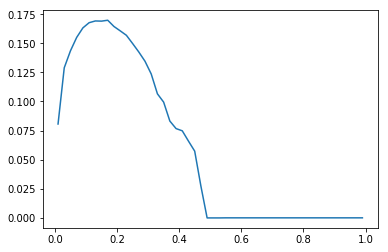

In [12]:
# cv without downsampling

skf = StratifiedKFold(n_splits=3)
preds = np.ones(y.shape[0])
rfc = RandomForestClassifier(n_estimators=325, min_samples_split=100,
                             n_jobs=-1, oob_score=True, random_state=42)


cnt = 0
for train, test in skf.split(X, y):
    print(sorted(Counter(y[train]).items()))
    X_resampled, y_resampled = X[train], y[train]
    print(sorted(Counter(y[train]).items()))
    print('start cv fold ', cnt)
    preds[test] = rfc.fit(X_resampled, y_resampled).predict_proba(X[test])[:,1]
    print("fold {}, ROC AUC: {:.3f}".format(cnt, roc_auc_score(y[test], preds[test])))
    cnt+=1
    
print(roc_auc_score(y, preds))
thresholds = np.linspace(0.01, 0.99, 50)
mcc = np.array([matthews_corrcoef(y, preds>thr) for thr in thresholds])
plt.plot(thresholds, mcc)
best_threshold = thresholds[mcc.argmax()]
print('mcc: ', mcc.max())